In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [24]:
g = 9.81 #重力加速度
m = 0.1125 #質点の質量
k = 0.4 #バネ定数
l = 0.1375 #バネの自然長

pos_0 = casadi.DM.zeros(3)
G = casadi.DM([0,0,g])

ns = 5 #バネの個数

nu = 3 #制御変数の次元
nx = 2*3*(ns-1)+3 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([0,0,0]*(ns-1)+[12.5,12.5,12.5]+[125,125,125]*(ns-1))
Q_f = casadi.diag([0,0,0]*(ns-1)+[10,10,10]+[0,0,0]*(ns-1))
R = casadi.diag([0.5,0.5,0.5])

# 予測ホライズン等
T = 8
K = 40
dt = T/K

# 制約条件
x_lb = [-np.inf]*nx
x_ub = [np.inf]*nx
u_lb = [-1]*nu
u_ub = [1]*nu

x_ref = casadi.DM([0,0,0]*(ns-1)+[7.5,0,0]+[0,0,0]*(ns-1))

total = nx*(K+1) + nu*K

In [25]:
def make_spring_force():
    pos_i = casadi.SX.sym("pos_i",3)
    pos_i1 = casadi.SX.sym("pos_i1",3)
    pos_rel = pos_i1 - pos_i
    norm = casadi.norm_2(pos_rel)
    force = k*(norm - l)*pos_rel/norm

    F = casadi.Function("F",[pos_i,pos_i1],[force],['pos_i','pos_i1'],['F'])
    return F

def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    F = make_spring_force()
    offset = 3*ns

    X_dot = []
    V_dot = []

    for k in range(ns-1):
        vel = states[offset+3*k:offset+3*(k+1)]
        X_dot.append(vel)

        pos = states[3*k:3*(k+1)]
        pos_n = states[3*(k+1):3*(k+2)]
        pos_p = states[3*(k-1):3*k] if k != 0 else pos_0
        vel_dot = (F(pos_i=pos,pos_i1=pos_n)["F"]-F(pos_i=pos_p,pos_i1=pos)["F"])/m - G
        V_dot.append(vel_dot)

    states_dot = casadi.vertcat(*X_dot,ctrls,*V_dot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u,u)) / 2
    return cost

def compute_final_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [26]:
def make_nlp():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k])*dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_final_cost(X[-1])

    option = {'print_time':False,"verbose":False}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [27]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [28]:
S = make_nlp()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    22053
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    16740

Total number of variables............................:     1200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1080
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.9594452e+03 8.41e+00 1.47e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

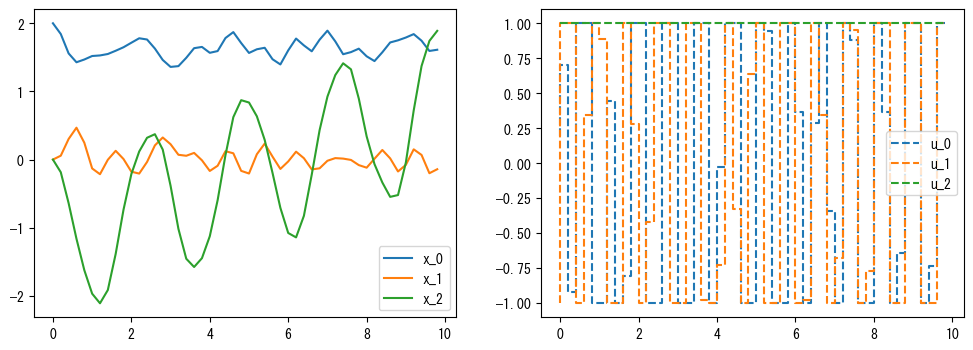

In [32]:
np.random.seed(0)

t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([2,0,0,3.5,0,0,5,0,0,6.5,0,0,8,0,0,0,0,0,0,3,0,0,0,0,0,0,0])
x0 = casadi.DM(np.random.normal(size=total))

I = make_integrator()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(3):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()

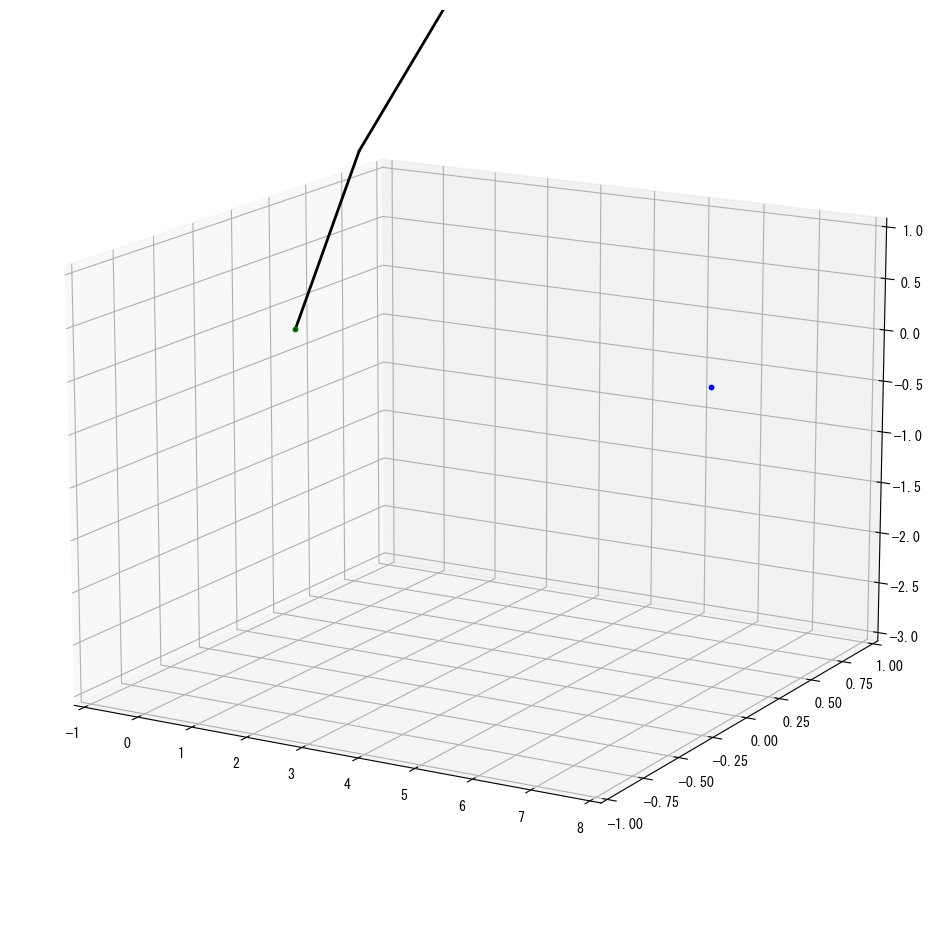

In [31]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection="3d")
frames = np.arange(0,t_eval.size)
fps = 1 / dt

def update_figure(i):
    x_lim_min = -1
    x_lim_max = 8
    y_lim_min = -1
    y_lim_max = 1
    z_lim_min = -3
    z_lim_max = 1

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_zlim(z_lim_min, z_lim_max)
    ax.view_init(elev=15)

    points = X[i,:3*ns]
    points = np.concatenate([np.zeros(3),points])
    points = points.reshape(-1,3)
    vel = U[i]

    ax.scatter(*points.T,color="black", s=2)
    ax.plot(*points.T, color='black', lw=2)
    ax.quiver(*points[-1],*vel, length=1.0,normalize=False)

    left = np.zeros(3)
    right = x_ref.full().ravel()[3*(ns-1):3*ns]
    ax.scatter(*left,color="green", s=10)
    ax.scatter(*right,color="blue", s=10)

ani = FuncAnimation(fig, update_figure, frames=frames)
ani.save("images/chap7_chain_of_mass.gif",writer="pillow",fps=fps)

In [ ]:
# import glob
# import natsort
# import cv2
# for i in np.linspace(0,199,12):
#     i = int(i)
#     update_figure(i)
#     fig.savefig(f"./tmp/_frame_{i}.png")
# paths = glob.glob("./tmp/*.png")
# paths = natsort.natsorted(paths)
# paths = [cv2.imread(path) for path in paths]
# paths = np.stack(paths,axis=0)
# paths = paths.reshape(4,3,600,1200,3)
# paths = np.concatenate(paths,axis=1)
# paths = np.concatenate(paths,axis=1)
# # paths = cv2.resize(paths,dsize=None,fx=1/3,fy=1/3)
# cv2.imwrite("images/chap5_cart_pole_anim.png",paths)

array([7.5, 0. , 0. ])